In [1]:
#General imports 
import sys
import os
from datetime import datetime, timedelta, date
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
from retrieve_time import Retrieve_Timestamps
%matplotlib inline

In [2]:
#Initialize relevant variables
M = {}
time_format = '%Y-%m-%d %H:%M:%S.%f'

In [3]:
#Set matplotlib variables for prettier plots.
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
fs = 36.

## Collect the data

In [4]:
#Read the sleep data.
fpath = './../data/step_count.csv'
data = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)
print(data.head(n=5))

                  end_time               start_time  count  calorie  \
0  2018-04-30 18:21:59.999  2018-04-30 18:21:00.000    101     4.29   
1  2018-04-13 19:47:59.999  2018-04-13 19:47:00.000     25     0.96   
2  2018-04-02 10:01:59.999  2018-04-02 10:01:00.000     38     1.53   
3  2018-04-27 10:52:59.999  2018-04-27 10:52:00.000     35     1.45   
4  2018-04-21 13:47:00.000  2018-04-21 13:46:00.000      0     0.00   

               update_time     speed                     pkg_name time_offset  \
0  2018-04-30 18:35:00.291  1.527778  com.sec.android.app.shealth    UTC-0300   
1  2018-04-13 19:55:00.251  1.027778  com.sec.android.app.shealth    UTC-0300   
2  2018-04-02 10:14:58.210  1.194444  com.sec.android.app.shealth    UTC-0300   
3  2018-04-27 10:55:01.281  1.500000  com.sec.android.app.shealth    UTC-0300   
4  2018-04-21 13:46:36.801  0.000000  com.sec.android.app.shealth    UTC-0300   

   distance                              datauuid              create_time  
0     78.

In [6]:
#Create datetime objects and collect the bedtime hours.
starttime_obj = Retrieve_Timestamps(data['start_time'].values, data['time_offset'].values, 'UTC', time_format).out
endtime_obj = Retrieve_Timestamps(data['end_time'].values, data['time_offset'].values, 'UTC', time_format).out

print('Start date: ', (min(starttime_obj)))
print('End date: ', (max(starttime_obj)))

#Compute sleep duration. This is, supposedly always 1min.
duration = endtime_obj - starttime_obj
M['duration'] = np.array([t.days*24.*60 + t.seconds/60. for t in duration]) #In minutes
assert not np.isnan(M['duration']).any(), "Error: M['duration'] contains NaN"


ref_date = min(starttime_obj)
time_prog = starttime_obj - ref_date
M['time_prog'] = np.array([t.days + t.seconds/86400. for t in time_prog]) #In days

M['start_hour'] = np.array([t.hour + t.minute/60. + t.second/3600. for t in starttime_obj])

M['distance'] = data['distance'].values
M['count'] = data['count'].values
M['speed'] = data['speed'].values
M['time_offset'] = data['time_offset'].values
M['Start_time_obj'] = starttime_obj


#Make pandas dataframe out of the master dictionary M. Useful for seaborn lmplot function.
df = pd.DataFrame(M)

Start date:  2018-03-31 04:01:00-03:00
End date:  2018-05-03 06:17:00-03:00


## Histogram start time, duration, counts, speed, distance

(array([  12.,    8.,   23.,   95.,  867., 1038.,  450.,  561.,  587.,
         711.,  406.,  529.,  709.,  695.,  785.,  641.,  616.,  552.,
         274.,  120.,   39.,   24.,    2.,   14.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]),
 <a list of 24 Patch objects>)

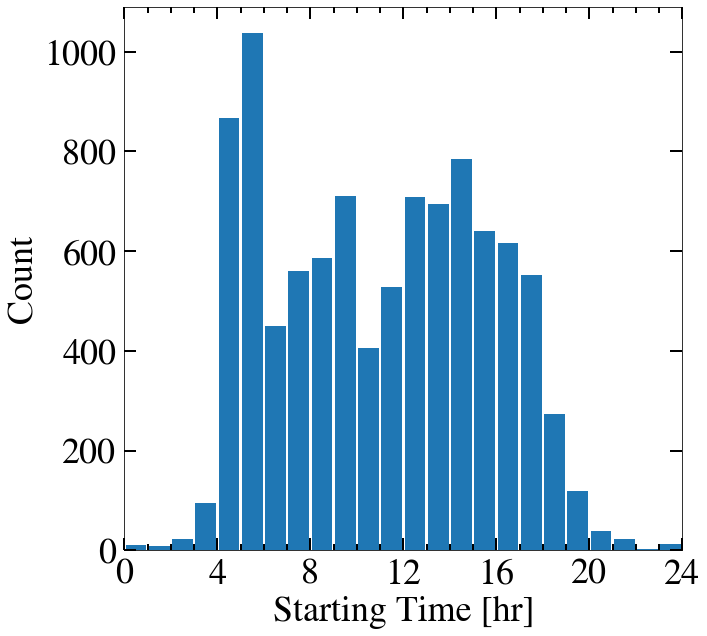

In [7]:
#First, make figure frame
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

xlabel = r'Starting Time [hr]'
ylabel = r'Count'
ax.set_xlabel(xlabel, fontsize=fs)
ax.set_ylabel(ylabel, fontsize=fs)
ax.set_xlim(0., 24.)
#ax.set_ylim(25., 175.)
ax.tick_params(axis='y', which='major', labelsize=fs, pad=8)      
ax.tick_params(axis='x', which='major', labelsize=fs, pad=8)
ax.tick_params('both', length=12, width=2., which='major',
                     direction='in', right=True, top=True)
ax.tick_params('both', length=6, width=2., which='minor',
                     direction='in', right=True, top=True) 
ax.xaxis.set_minor_locator(MultipleLocator(1.))
ax.xaxis.set_major_locator(MultipleLocator(4.))
#ax.yaxis.set_minor_locator(MultipleLocator(10.))
#ax.yaxis.set_major_locator(MultipleLocator(20.))

#Plot data.

ax.hist(M['start_hour'], bins=np.arange(0,24.1,1), rwidth=0.9)

## Corner plot with relevant variables.
This shows that quantities can be integrated over a day.

Index(['duration', 'time_prog', 'start_hour', 'distance', 'count', 'speed',
       'time_offset', 'Start_time_obj'],
      dtype='object')


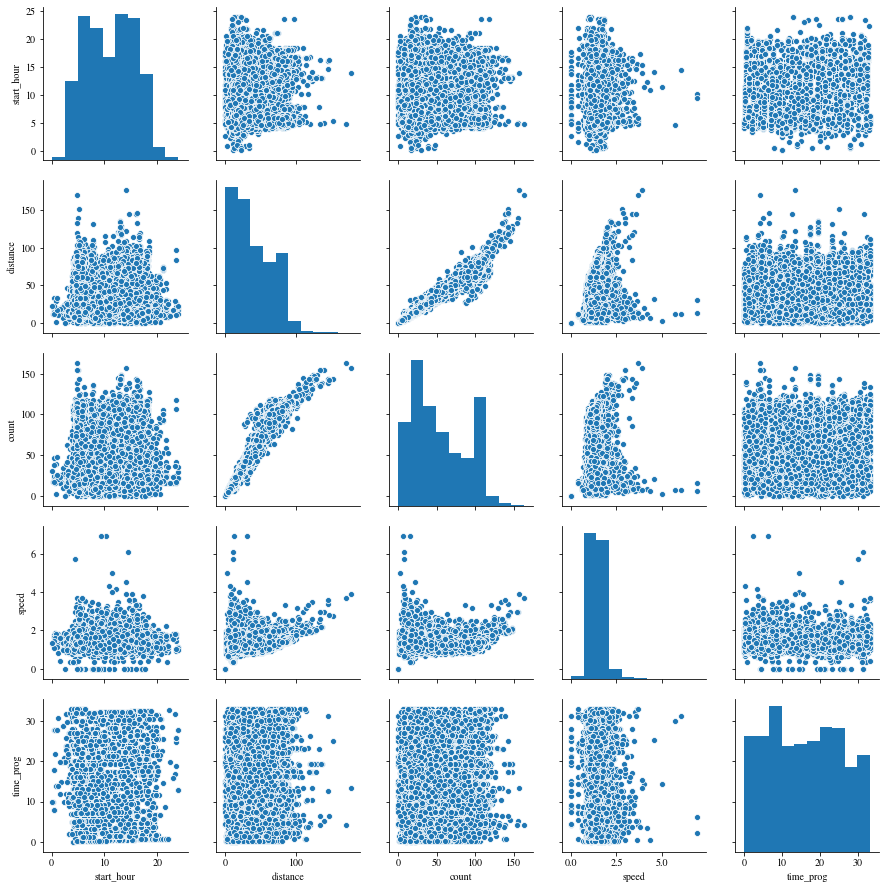

In [8]:
pair_cols = ['start_hour', 'distance', 'count', 'speed', 'time_prog']
print(df.columns)
df2 = df[pair_cols]
g = sns.pairplot(df2)

## Combine data per day.

In [65]:
#Create new dictionary with the relevant columns to be resampled.
pair_cols = ['Start_time_obj', 'distance', 'count', 'speed', 'duration']
df3 = df[pair_cols]

df3 = df3.resample('D', on='Start_time_obj').agg({'distance':'sum', 'duration':'sum',
                                                  'count':'sum', 'speed':'mean', })

## Make corner plot of the combined data

34 (34, 5)


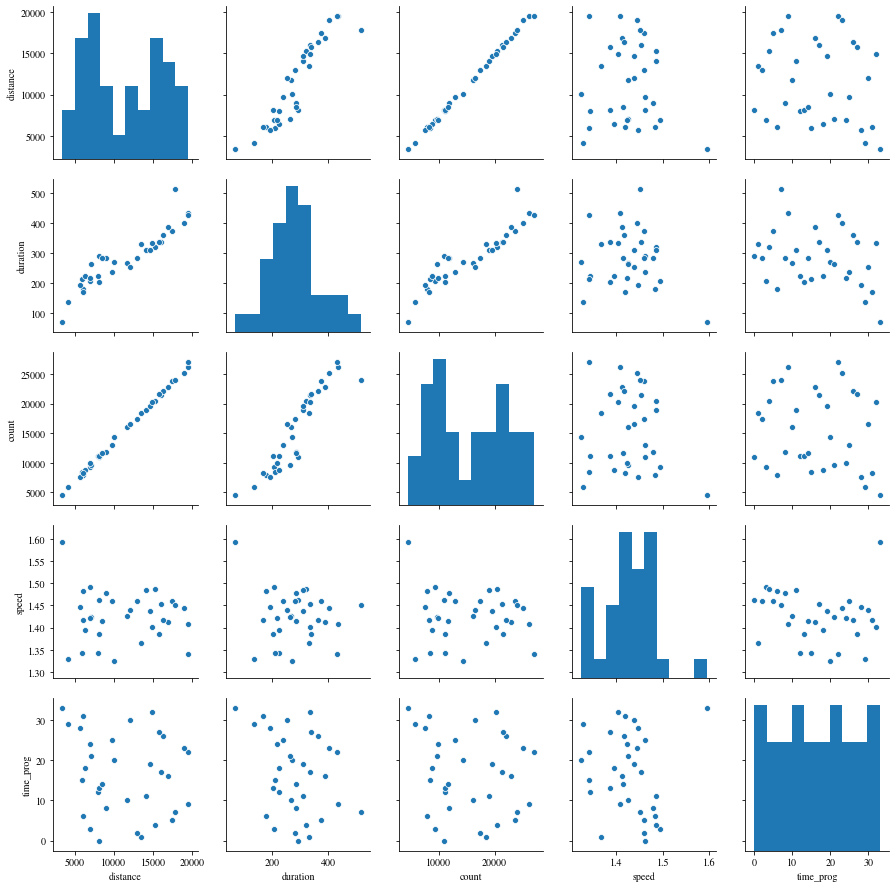

In [69]:
df3['time_prog'] = np.arange(df3.shape[0])
g = sns.pairplot(df3)